In [1]:
library(tidyverse)

load("all/data_AQ.rda")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
head(data_AQ)

,date,site,variable,value
,<dttm>,<fct>,<fct>,<dbl>
1,2017-01-01,es0041a,no2,42.33333
2,2017-01-02,es0041a,no2,48.16667
3,2017-01-03,es0041a,no2,54.50000
4,2017-01-04,es0041a,no2,51.95833
5,2017-01-05,es0041a,no2,58.12500
6,2017-01-06,es0041a,no2,49.54167


In [4]:
anuales <- merge(x = data_AQ, 
                 y = read.csv("Curation/checked_AQ.csv") %>%
                        select(site, variable, site_name, Municipio), 
                 by = c("site", "variable"), all.x=T, all.y=F) %>%
            filter(variable %in% c("no2", "pm10", "pm2.5")) %>%
            openair::timeAverage(avg.time = "year", 
                                 data.thresh = 0.75, 
                                 type = c("site", "variable", 
                                          "Municipio", "site_name")) %>%
            mutate(date = as.factor(lubridate::year(date))) %>%
            arrange(site, variable, date)
anuales$date <- factor(anuales$date, levels=c(2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020))

head(anuales)

site,variable,Municipio,site_name,date,value
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
es0041a,no2,Bilbao,DIRECCIÓN DE SALUD,2017,42.82362
es0041a,no2,Bilbao,DIRECCIÓN DE SALUD,2018,39.17607
es0041a,no2,Bilbao,DIRECCIÓN DE SALUD,2019,35.73909
es0041a,no2,Bilbao,DIRECCIÓN DE SALUD,2020,26.36192
es0041a,pm10,Bilbao,DIRECCIÓN DE SALUD,2017,20.03396
es0041a,pm10,Bilbao,DIRECCIÓN DE SALUD,2018,20.39945


| Contaminantes | 2020 | 2021 | UE
|:--:|:--:|:--:|:--:|
|NO<sub>2</sub> | 40 | 10 | 40 |
| PM2.5 | 10 | 5 | 25 |
| PM10 | 20 | 15 | 40 |


In [5]:
a <- anuales %>%
    group_by(variable, date, Municipio) %>%
    summarise(value = mean(value, na.rm=T)) %>%
    mutate(UE = case_when(variable == "no2" ~ 40,
                          variable == "pm10" ~ 40,
                          variable == "pm2.5" ~ 25,
                         ),
           OMS_2005 = case_when(variable == "no2" ~ 40,
                                variable == "pm10" ~ 20,
                                variable == "pm2.5" ~ 10,
                               ),
           OMS_2021 = case_when(variable == "no2" ~ 10,
                                variable == "pm10" ~ 15,
                                variable == "pm2.5" ~ 5,
                               ))

`summarise()` has grouped output by 'variable', 'date'. You can override using the `.groups` argument.



Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”


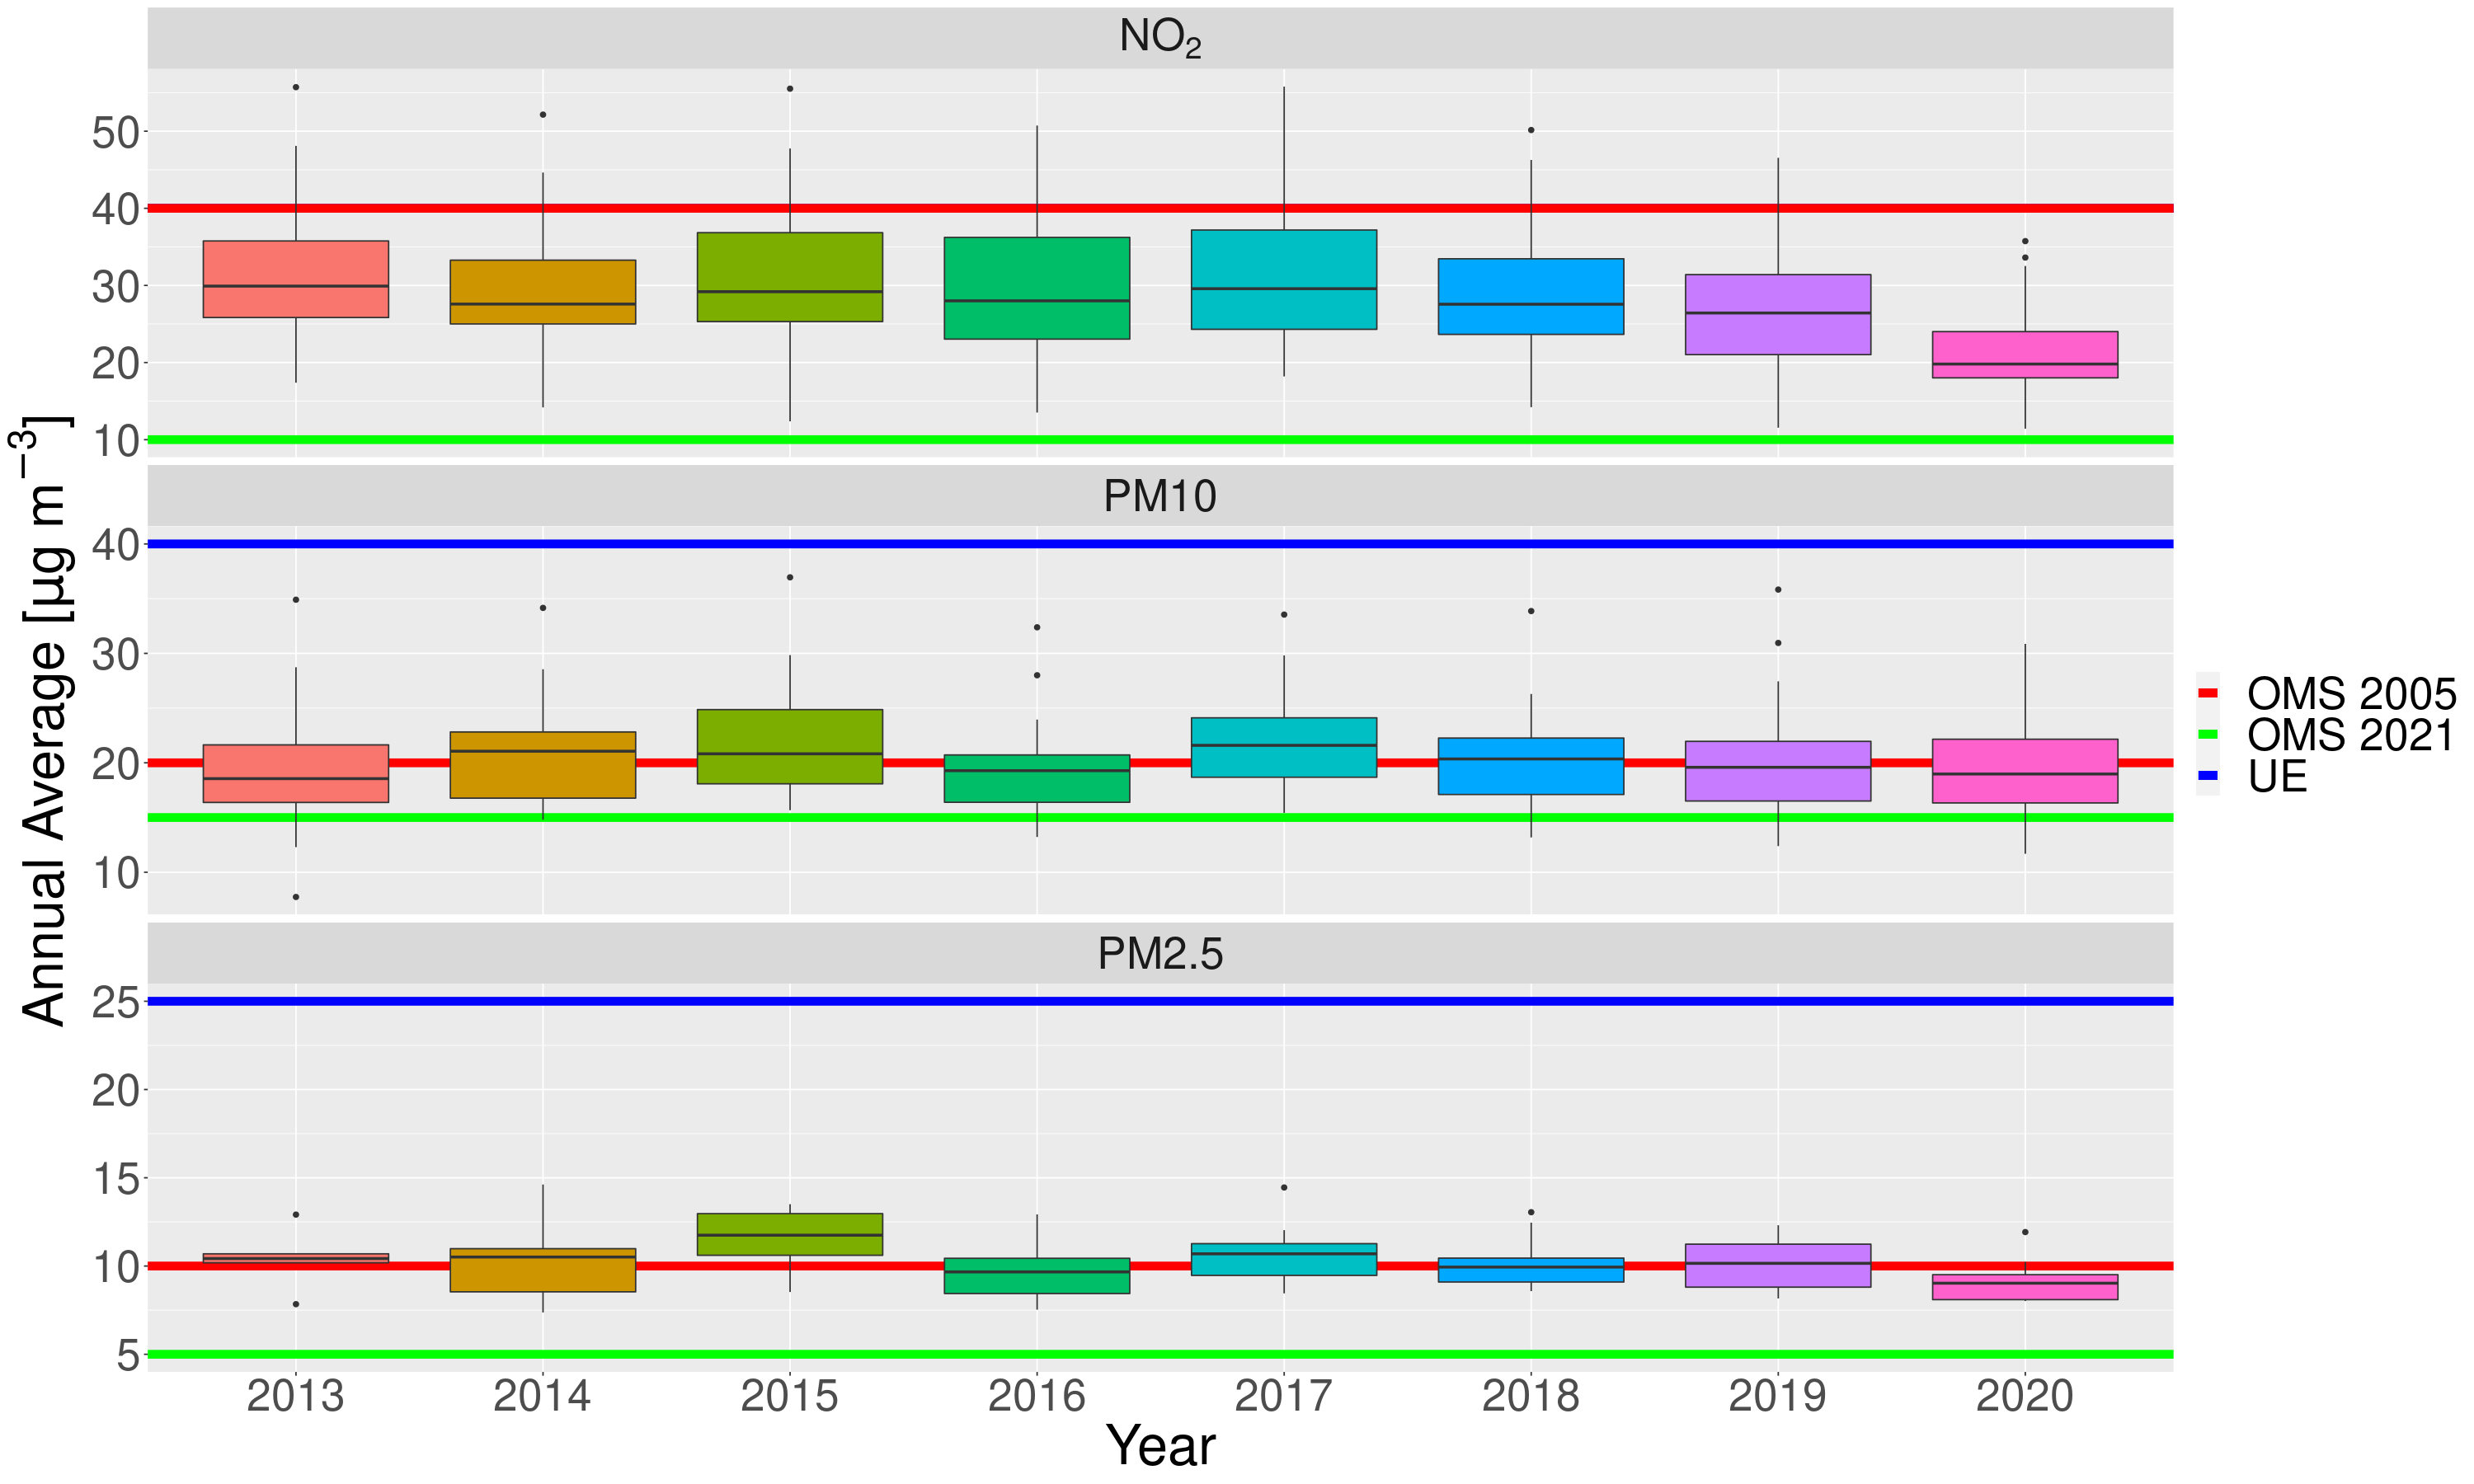

In [6]:
library(ggplot2)

r.variable <- c("no2" = expression(NO[2]),
                "pm10" = expression(PM10),
                "pm2.5" = expression(PM2.5)
               )

plot.data <- a

plot.data$variable <- factor(plot.data$variable, 
                           labels=r.variable)

ggplot(data = plot.data  %>% rename(Year = date), ) +
    theme(text = element_text(size=40),
          legend.title = element_blank()) + 
    guides(fill = FALSE) +
    geom_hline(aes(yintercept=UE,
               color = "UE"), size = 3) +
    geom_hline(aes(yintercept=OMS_2005,
               color = "OMS 2005"), size = 3) +
    geom_hline(aes(yintercept=OMS_2021,
               color = "OMS 2021"), size = 3) +
    scale_y_continuous(name=expression(paste("Annual Average [", mu, "g ", m^-3, "]"))) +
    geom_boxplot(aes(x=Year, 
                     y=value, 
                     fill=Year)) +
    facet_wrap(~variable, ncol=1, scale="free_y", 
               labeller = labeller(variable=label_parsed)) +
    scale_colour_manual(values = c("UE"="blue",
                                   "OMS 2005" = "red", 
                                   "OMS 2021" = "green")) 

In [7]:
ggsave(filename = "./plot.jpg", plot = last_plot(), width = 20, height = 15)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”


In [8]:
amount <- merge(a %>%
                    filter(value <= UE) %>%
                    group_by(variable, date) %>%
                    summarise(UE_n = n(),
                              "UE_" = 100*UE_n),
                a %>%
                    filter(value <= OMS_2005) %>%
                    group_by(variable, date) %>%
                    summarise(OMS_2005_n = n(),
                              "OMS_2005_" = 100*OMS_2005_n),
                by = c("variable", "date"), all=T)

all.amount <- merge(amount,
                a %>%
                    filter(value <= OMS_2021) %>%
                    group_by(variable, date) %>%
                    summarise(OMS_2021_n = n(),
                              "OMS_2021_" = 100*OMS_2021_n),
                by = c("variable", "date"), all=T) %>% arrange(variable, date)

all.amount[is.na(all.amount)] <-0

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.



In [9]:
all.amount <- all.amount %>% 
    mutate("UE_" = case_when(variable == "no2" ~ UE_ / 34,
                             variable == "pm10" ~ UE_ / 22,
                             variable == "pm2.5" ~ UE_ / 9
                            ),
           "OMS_2005_" = case_when(variable == "no2" ~ OMS_2005_ / 34,
                                   variable == "pm10" ~ OMS_2005_ / 22,
                                   variable == "pm2.5" ~ OMS_2005_ / 9
                                  ),
           "OMS_2021_" = case_when(variable == "no2" ~ OMS_2021_ / 34,
                                   variable == "pm10" ~ OMS_2021_ / 22,
                                   variable == "pm2.5" ~ OMS_2021_ / 9
                                  )
          ) %>% 
    rename("UE_%" = "UE_",
           "OMS_2005_%" = "OMS_2005_",
           "OMS_2021_%" = "OMS_2021_")

In [10]:
all.amount

variable,date,UE_n,UE_%,OMS_2005_n,OMS_2005_%,OMS_2021_n,OMS_2021_%
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
no2,2013,29,85.29412,29,85.29412,0,0.000000
no2,2014,28,82.35294,28,82.35294,0,0.000000
no2,2015,27,79.41176,27,79.41176,0,0.000000
no2,2016,30,88.23529,30,88.23529,0,0.000000
no2,2017,29,85.29412,29,85.29412,0,0.000000
no2,2018,30,88.23529,30,88.23529,0,0.000000
no2,2019,31,91.17647,31,91.17647,0,0.000000
no2,2020,34,100.00000,34,100.00000,0,0.000000
pm10,2013,20,90.90909,11,50.00000,5,22.727273


In [11]:
library(openxlsx)

In [12]:
write.xlsx(all.amount, file="estaciones_superaciones.xlsx")

```R
# INFORMACION DE LAS ESTACIONES EN EXCEL
excel.info <- list("estaciones-no2" = resumen %>% filter(variable == "no2"), 
                   "estaciones-pm10" = resumen %>% filter(variable == "pm10"), 
                   "estaciones-pm2.5" = resumen %>% filter(variable == "pm2.5"), 
                   
                   "municipios-no2" = resumen %>% filter(variable == "no2") %>%
                                           group_by(variable, date, Municipio,) %>%
                                           summarise(value = mean(value, na.rm=T)), 
                   "municipios-pm10" = resumen %>% filter(variable == "pm10") %>%
                                           group_by(variable, date, Municipio,) %>%
                                           summarise(value = mean(value, na.rm=T)), 
                   "municipios-pm2.5" = resumen %>% filter(variable == "pm2.5") %>%
                                          group_by(variable, date, Municipio) %>%
                                           summarise(value = mean(value, na.rm=T)), 
                   
                   "2020-municipios-no2" = resumen %>% 
                                               filter(variable == "no2",
                                                      date == 2020) %>%
                                               group_by(variable, date, Municipio,) %>%
                                               summarise(value = mean(value, na.rm=T)), 
                   "2020-municipios-pm10" = resumen %>% 
                                               filter(variable == "pm10",
                                                      date == 2020) %>%
                                               group_by(variable, date, Municipio,) %>%
                                               summarise(value = mean(value, na.rm=T)), 
                   "2020-municipios-pm2.5" = resumen %>% 
                                               filter(variable == "pm2.5",
                                                      date == 2020) %>%
                                               group_by(variable, date, Municipio) %>%
                                               summarise(value = mean(value, na.rm=T))
                   )

write.xlsx(excel.info, file="medias-anuales.xlsx")
```